# TODO: whiten input data

My interpolation scheme is silly. Yes I am using the analytic relation, but really I should do this:

- not use analytic relation at all
- maybe not consider coords in focal plane? or downweight (yes pupil contribution)

I would like to create some kind of gaussian process for it.

There are two aspects to this: interpolation of the zernike terms, and then connecting that to the ellipticities.

# Look at Interpolation between zernike points

also compare them with the interpolation scheme implimented by default (timing, difference, smoothness? Do I even expect it to be smoother?)

Can I create a 'test' dataset? Here is how: take mesh and create a test subset from it. Then from the training set create a training / validation subset

In [3]:
%matplotlib inline
from sklearn import cross_validation
import numpy as np
import os
import pandas as pd
from WavefrontPSF.decamutil_cpd import decaminfo
dec = decaminfo()

path = '/Users/cpd/Desktop/ComboMeshes-old/'
path_out = '/Users/cpd/Desktop/ComboMeshes2/'
mesh_name = 'Science-20140212s2-v1i2_All'#'Science-20121120s1-v1i2_All'
dTrains = []
dTests = []
dVals = []
fileTitle = 'z{0}'.format(4) + 'Mesh_' + mesh_name
if os.path.exists(path_out + 'Mesh_' + mesh_name + '_val.dat'):
    
    trainName = path_out + 'Mesh_' + mesh_name + '_train.dat'
    dTrains = pd.read_csv(trainName)
    testName = path_out + 'Mesh_' + mesh_name + '_test.dat'
    dTests = pd.read_csv(testName)
    valName = path_out + 'Mesh_' + mesh_name + '_val.dat'
    dVals = pd.read_csv(valName)

    
else:
    fileTitle = 'z{0}'.format(4) + 'Mesh_' + mesh_name
    fileName = path + fileTitle + '.dat'
    dataPoints = np.loadtxt(fileName, dtype=[('Sensor','|S3'),('x','float'),('y','float'),('z','float'),('w','float')])
    dTrain_base_indx, dTest_indx = cross_validation.train_test_split(np.arange(len(dataPoints)))
    # divide the dTrain_base_indx into dTrain_indx and dVal_indx
    dTrain_indx, dVal_indx = cross_validation.train_test_split(np.arange(len(dTrain_base_indx)))
    
    sensor = dataPoints['Sensor']
    # convert sensor to chip id
    x = dataPoints['x']
    y = dataPoints['y']
    
    columns = ['x', 'y', 'ccdnum']
    ccdnum = [dec.infoDict[sensor_i]['CCDNUM']
              for sensor_i in sensor]
    coords = np.array([x, y, ccdnum]).T
    dTests = coords[dTest_indx]
    dTrains = coords[dTrain_base_indx][dTrain_indx]
    dVals = coords[dTrain_base_indx][dVal_indx]
    for zi in range(4, 12):
        fileTitle = 'z{0}'.format(zi) + 'Mesh_' + mesh_name
        fileName = path + fileTitle + '.dat'
        zkey = 'z{0}'.format(zi)
        wkey = 'w{0}'.format(zi)
        columns += [zkey, wkey]
        
        dataPoints = np.loadtxt(fileName, dtype=[('Sensor','|S3'),('x','float'),('y','float'),
                                                 (zkey, 'float'),(wkey,'float')])

        dTests = np.hstack((dTests,
                            dataPoints[zkey][dTest_indx][:, np.newaxis],
                            dataPoints[wkey][dTest_indx][:, np.newaxis]))
        dTrains = np.hstack((dTrains,
                            dataPoints[zkey][dTrain_base_indx][dTrain_indx][:, np.newaxis],
                            dataPoints[wkey][dTrain_base_indx][dTrain_indx][:, np.newaxis]))
        dVals = np.hstack((dVals,
                            dataPoints[zkey][dTrain_base_indx][dVal_indx][:, np.newaxis],
                            dataPoints[wkey][dTrain_base_indx][dVal_indx][:, np.newaxis]))
        # save!
        trainName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_train.dat'
        np.savetxt(trainName, dataPoints[dTrain_base_indx][dTrain_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])
        testName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_test.dat'
        np.savetxt(testName, dataPoints[dTest_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])
        valName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_val.dat'
        np.savetxt(valName, dataPoints[dTrain_base_indx][dVal_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])

    # save!
    trainName = path_out + 'Mesh_' + mesh_name + '_train.dat'
    df = pd.DataFrame(dTrains, columns=columns)
    df.to_csv(trainName)
    dTrains = df
    testName = path_out + 'Mesh_' + mesh_name + '_test.dat'
    df = pd.DataFrame(dTests, columns=columns)
    df.to_csv(testName)
    dTests = df
    valName = path_out + 'Mesh_' + mesh_name + '_val.dat'
    df = pd.DataFrame(dVals, columns=columns)
    df.to_csv(valName)
    dVals = df

Now load up the object in FP class and make its predictions about the test and validation sets

In [4]:
if os.path.exists(path_out + 'Mesh_' + mesh_name + '_train_DA.dat'):
    trainName = path_out + 'Mesh_' + mesh_name + '_train_DA.dat'
    dTrains_FPF = pd.read_csv(trainName)
    testName = path_out + 'Mesh_' + mesh_name + '_test_DA.dat'
    dTests_FPF = pd.read_csv(testName)
    valName = path_out + 'Mesh_' + mesh_name + '_val_DA.dat'
    dVals_FPF = pd.read_csv(valName)
else:
    from WavefrontPSF.focal_plane_fit import FocalPlaneFit

    FPF = FocalPlaneFit(path_mesh=path_out, mesh_name=mesh_name + '_train')
    column_names = ['x', 'y', 'ccdnum']

    # dTests
    dTests_FPF = dTests[column_names].copy()
    ccdnums = dTests_FPF['ccdnum'].unique()
    for i, zi in enumerate(xrange(4, 12)):
        dTests_FPF['z{0}'.format(zi)] = 0
    for ccdnum in ccdnums:
        sensor = dec.ccddict[ccdnum]
        conds = dTests_FPF['ccdnum'] == ccdnum
        xs = dTests_FPF['x'][conds]
        ys = dTests_FPF['y'][conds]
        for i, zi in enumerate(xrange(4, 12)):
            zernike = FPF.da.meshDict['z{0}Mesh'.format(zi)].doInterp(sensor, xs, ys)
            dTests_FPF['z{0}'.format(zi)][conds] = zernike
    # now save the FPF predictions
    testName = path_out + 'Mesh_' + mesh_name + '_test_DA.dat'
    dTests_FPF.to_csv(testName)

    # dTrains
    dTrains_FPF = dTrains[column_names].copy()
    ccdnums = dTrains_FPF['ccdnum'].unique()
    for i, zi in enumerate(xrange(4, 12)):
        dTrains_FPF['z{0}'.format(zi)] = 0
    for ccdnum in ccdnums:
        sensor = dec.ccddict[ccdnum]
        conds = dTrains_FPF['ccdnum'] == ccdnum
        xs = dTrains_FPF['x'][conds]
        ys = dTrains_FPF['y'][conds]
        for i, zi in enumerate(xrange(4, 12)):
            zernike = FPF.da.meshDict['z{0}Mesh'.format(zi)].doInterp(sensor, xs, ys)
            dTrains_FPF['z{0}'.format(zi)][conds] = zernike
    # now save the FPF predictions
    trainName = path_out + 'Mesh_' + mesh_name + '_train_DA.dat'
    dTrains_FPF.to_csv(trainName)

    # dVals
    dVals_FPF = dVals[column_names].copy()
    ccdnums = dVals_FPF['ccdnum'].unique()
    for i, zi in enumerate(xrange(4, 12)):
        dVals_FPF['z{0}'.format(zi)] = 0
    for ccdnum in ccdnums:
        sensor = dec.ccddict[ccdnum]
        conds = dVals_FPF['ccdnum'] == ccdnum
        xs = dVals_FPF['x'][conds]
        ys = dVals_FPF['y'][conds]
        for i, zi in enumerate(xrange(4, 12)):
            zernike = FPF.da.meshDict['z{0}Mesh'.format(zi)].doInterp(sensor, xs, ys)
            dVals_FPF['z{0}'.format(zi)][conds] = zernike
    # now save the FPF predictions
    valName = path_out + 'Mesh_' + mesh_name + '_val_DA.dat'
    dVals_FPF.to_csv(valName)

# Analyze the results of the FPF interpolation

<class 'pandas.core.frame.DataFrame'>


<function __main__.comparison_center>

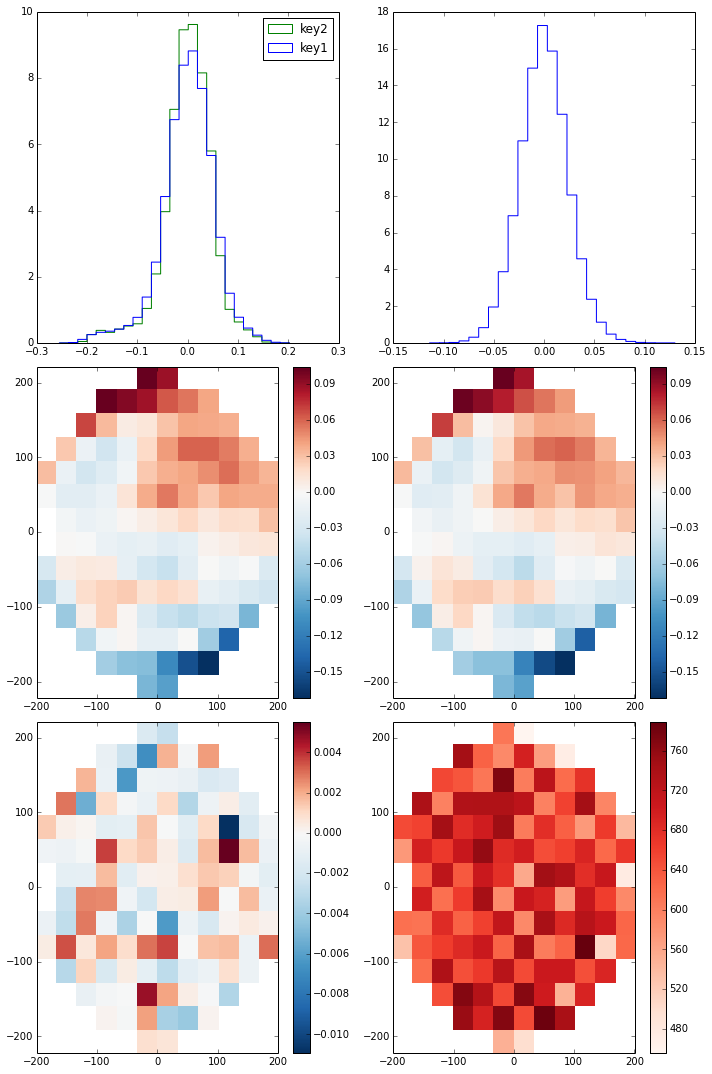

In [7]:
from IPython.html.widgets import interact
from WavefrontPSF.colors import shiftedColorMap

dec = decaminfo()

def mad(x):
    return np.median(np.abs(x - np.median(x)))

def compare_plots(zi, data1, data2, smoothfunc, numbins):
    key = 'z{0}'.format(zi)
    fig, axes = plt.subplots(nrows=3, ncols=2,
                             figsize=(10,15),
                             squeeze=False)
    if numbins < 6:
        numbins_hist = 25
    else:
        numbins_hist = numbins
    # first row has two histograms for the distribution of values and their differences
    ax = axes[0, 0]
    ax.hist([data1[key], data2[key]], bins=numbins_hist, label=['key1', 'key2'], histtype='step',
            normed=True)

    ax.legend(loc='upper right')

    # second column is the difference
    if len(data2[key]) == len(data1[key]):
        ax = axes[0, 1]
        ax.hist(data2[key] - data1[key], bins=numbins_hist, histtype='step',
                normed=True)
    else:
        axes[0, 1].set_axis_off()
#     axes[0, 2].set_axis_off()
#     # second row has focal plane distributions and such binned by smoothfunc and numbins
#     fig, axes = plt.subplots(nrows=1, ncols=3,
#                              figsize=(18,5),
#                              squeeze=False)
    x = data1['x']
    y = data1['y']
    x2 = data2['x']
    y2 = data2['y']

    if numbins < 6:
        bins_x, bins_y = dec.getEdges(numbins)
    else:
        bins_x = np.linspace(np.min((x.min(), x2.min())),
                             np.max((x.max(), x2.max())),
                             numbins)#x.min(), x.max(), numbins)
        bins_y = np.linspace(np.min((y.min(), y2.min())),
                             np.max((y.max(), y2.max())),
                             numbins)#y.min(), y.max(), numbins)

    groups1 = data1.groupby([pd.cut(x, bins_x), pd.cut(y, bins_y)])
    groups2 = data2.groupby([pd.cut(x2, bins_x), pd.cut(y2, bins_y)])

    agg1 = groups1.aggregate(smoothfunc)
    agg2 = groups2.aggregate(smoothfunc)
    # filter out nanmins on key (which should also filter x and y?!)
    agg1 = agg1[agg1[key].notnull()]
    agg2 = agg2[agg2[key].notnull()]
    # figure out the cmap here
    b = np.max([agg1[key].max(),
                agg2[key].max()])
    a = np.min([agg1[key].min(),
                agg2[key].min()])
    c = 0
    midpoint = (c - a) / (b - a)
    if midpoint == 0:
        cmap = plt.cm.Reds
    else:
        cmap = shiftedColorMap(plt.cm.RdBu_r, midpoint=midpoint, start=0, stop=1)
    vmin = a
    vmax = b

    # I would like a little more control over these variables
    # so let's get the X, Y, and C 2d arrays
    # get the indices
    indx_x = agg1.index.labels[0].values()
    indx_y = agg1.index.labels[1].values()

    # here is something that is going to be irritating and cludgey:
    # let's get the values of the different bins (for sorting purposes)
    x_vals = np.array([np.mean(eval(ith.replace('(','['))) for
                       ith in agg1.index.levels[0]])
    y_vals = np.array([np.mean(eval(ith.replace('(','['))) for
                       ith in agg1.index.levels[1]])
    # now sort the order for the levels
    x_vals_argsorted = np.argsort(x_vals)
    y_vals_argsorted = np.argsort(y_vals)
    # now this means that the 0th entry in x_vals_argsorted comes first
    # so we want indx_x_transform to represent the sorted values
    # so instead of indx_x representing arbitrary bin i, we want it to
    # instead represent sorted bin j

    indx_x_transform = np.argsort(np.arange(len(x_vals))[np.argsort(x_vals)])[indx_x]
    indx_y_transform = np.argsort(np.arange(len(y_vals))[np.argsort(y_vals)])[indx_y]


    CNum = np.ma.zeros((indx_x.max() + 1, indx_y.max() + 1))
    CNum.mask = np.ones((indx_x.max() + 1, indx_y.max() + 1))

    # I think this might break if there are more than one value per index
    Nums = groups1.aggregate(len)
    Nums = Nums[Nums[key].notnull()]['x'].values

    # cludgey but holy shit was this confusing
    np.add.at(CNum, [indx_x_transform, indx_y_transform],
              Nums)
    np.multiply.at(CNum.mask, [indx_x_transform, indx_y_transform], 0)
    CNum = CNum.T

    ax = axes[2, 1]
    IM = ax.pcolor(bins_x, bins_y, CNum,
                     cmap=plt.cm.Reds,)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    plt.colorbar(IM, ax=ax)

    C1 = np.ma.zeros((indx_x.max() + 1, indx_y.max() + 1))
    C1.mask = np.ones((indx_x.max() + 1, indx_y.max() + 1))

    # I think this might break if there are more than one value per index
    np.add.at(C1, [indx_x_transform, indx_y_transform], agg1[key].values)
    np.multiply.at(C1.mask, [indx_x_transform, indx_y_transform], 0)
    C1 = C1.T

    ax = axes[1, 0]
    IM = ax.pcolor(bins_x, bins_y, C1,
                     cmap=cmap,
                     vmin=vmin, vmax=vmax)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    plt.colorbar(IM, ax=ax)



    # I would like a little more control over these variables
    # so let's get the X, Y, and C 2d arrays
    # get the indices
    indx_x = agg2.index.labels[0].values()
    indx_y = agg2.index.labels[1].values()

    # here is something that is going to be irritating and cludgey:
    # let's get the values of the different bins (for sorting purposes)
    x_vals = np.array([np.mean(eval(ith.replace('(','['))) for
                       ith in agg2.index.levels[0]])
    y_vals = np.array([np.mean(eval(ith.replace('(','['))) for
                       ith in agg2.index.levels[1]])
    # now sort the order for the levels
    x_vals_argsorted = np.argsort(x_vals)
    y_vals_argsorted = np.argsort(y_vals)
    # now this means that the 0th entry in x_vals_argsorted comes first
    # so we want indx_x_transform to represent the sorted values
    # so instead of indx_x representing arbitrary bin i, we want it to
    # instead represent sorted bin j

    indx_x_transform = np.argsort(np.arange(len(x_vals))[np.argsort(x_vals)])[indx_x]
    indx_y_transform = np.argsort(np.arange(len(y_vals))[np.argsort(y_vals)])[indx_y]
    C2 = np.ma.zeros((indx_x.max() + 1, indx_y.max() + 1))
    C2.mask = np.ones((indx_x.max() + 1, indx_y.max() + 1))

    # I think this might break if there are more than one value per index
    np.add.at(C2, [indx_x_transform, indx_y_transform], agg2[key].values)
    np.multiply.at(C2.mask, [indx_x_transform, indx_y_transform], 0)
    C2 = C2.T

    ax = axes[1, 1]
    IM = ax.pcolor(bins_x, bins_y, C2,
                     cmap=cmap,
                     vmin=vmin, vmax=vmax)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    plt.colorbar(IM, ax=ax)

    C21 = (C2 - C1)
    a = C21.min()
    b = C21.max()
    c = 0
    midpoint = (c - a) / (b - a)
    if midpoint == 0:
        cmap_diff = plt.cm.Reds
    else:
        cmap_diff = shiftedColorMap(plt.cm.RdBu_r, midpoint=midpoint)
    vmin_diff = a
    vmax_diff = b

    ax = axes[2, 0]
    IM = ax.pcolor(bins_x, bins_y, C21,
                     cmap=cmap_diff,
                     vmin=vmin_diff, vmax=vmax_diff)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    plt.colorbar(IM, ax=ax)

    plt.tight_layout()
    print(type(agg1))

#     ax = axes[0, 0]
#     data1.plot(kind='hexbin', x='x', y='y', C=key,
#                reduce_C_function=smoothfunc,
#                gridsize=numbins,
#                colormap=cmap,
#                vmin=vmin, vmax=vmax,
#                ax=ax)
#     ax = axes[0, 1]
#     data2.plot(kind='hexbin', x='x', y='y', C=key,
#                reduce_C_function=smoothfunc,
#                gridsize=numbins,
#                colormap=cmap,
#                vmin=vmin, vmax=vmax,
#                ax=ax)

#     data12 = data1 - data2
#     data12['x'] = x
#     data12['y'] = y
#     groups12 = data12.groupby([pd.cut(x, bins_x), pd.cut(y, bins_y)])
#     b = groups12.aggregate(smoothfunc)[key].max()
#     a = groups12.aggregate(smoothfunc)[key].min()
#     c = 0
#     midpoint = (c - a) / (b - a)
#     if midpoint == 0:
#         cmap_diff = reds
#     else:
#         cmap_diff = shiftedColorMap(blue_red, midpoint=midpoint)

#     ax = axes[0, 2]
#     data12.plot(kind='hexbin', x='x', y='y', C=key,
#                reduce_C_function=smoothfunc,
#                gridsize=numbins,
#                colormap=cmap_diff,
#                ax=ax)
#     plt.tight_layout()

#     data12.plot(kind='hexbin', x='x', y='y',
#                 gridsize=numbins)

def comparison_center(zi):
    return compare_plots(zi, data1=dTests, data2=dTests_FPF,
                         numbins=1,
                         smoothfunc=np.median)
interact(comparison_center,
         zi=(4, 11))

# This all is old and can be ignored

In [ ]:
ith = 11 - 4
plt.figure()
_ = plt.hist(dTests_FPF[ith] - dTests[ith]['z'], bins=100, histtype='step')
plt.figure()
_ = plt.hist2d(dTests[ith]['z'], dTests_FPF[ith] - dTests[ith]['z'], bins=100, vmin=1)
plt.xlabel('Truth')
plt.ylabel('Interp - Truth')

Take the training and validation sets and convert them to more meaningful arrays:

x, y coords (in focal plane, not chip) for 'x' and then the 'z's for the y, 'w' for yerr

In [2]:
from WavefrontPSF.decamutil_cpd import decaminfo
dec = decaminfo()
X = []
dTrains_cut_zi = dTrains_cut[0]
for dTrain in dTrains_cut_zi:
    extname, ix, iy, z, w = dTrain
    #X.append(dec.getPosition(extname, ix, iy))
    X.append([ix, iy])
X = np.array(X)
Y = []
Yerr = []
for dTrains_cut_zi in dTrains_cut:
    Y_i = []
    Yerr_i = []
    for dTrain in dTrains_cut_zi:
        extname, ix, iy, z, w = dTrain
        Y_i.append(z)
        Yerr_i.append(w)
    Y.append(Y_i)
    Yerr.append(Yerr_i)
Y = np.array(Y).T
Yerr = np.array(Yerr).T


# repeat for val
Xval = []
dVals_zi = dVals[0]
for dVal in dVals_zi:
    extname, ix, iy, z, w = dVal
    #Xval.append(dec.getPosition(extname, ix, iy))
    Xval.append([ix, iy])
Xval = np.array(Xval)
Yval = []
Yerrval = []
for dVals_zi in dVals:
    Y_i = []
    Yerr_i = []
    for dVal in dVals_zi:
        extname, ix, iy, z, w = dVal
        Y_i.append(z)
        Yerr_i.append(w)
    Yval.append(Y_i)
    Yerrval.append(Yerr_i)
Yval = np.array(Yval).T
Yerrval = np.array(Yerrval).T

In [23]:
def make_plots(x, y, bins=50, cmap='Blues'):
    counts, xedges, yedges = np.histogram2d(x[:,0], x[:,1], bins=bins)
#     plt.figure()
#     plt.pcolor(xedges, yedges, counts.T, cmap=cmap)
#     plt.colorbar()

    weighted_counts, xedges, yedges = np.histogram2d(x[:,0], x[:,1], bins=[xedges, yedges], weights=y)
    C = weighted_counts.T / counts.T
    C = np.where(counts.T == 0, np.nanmin(C), C)

    plt.figure()
    plt.pcolor(xedges, yedges, C, cmap=cmap)
    plt.colorbar()

#     plt.figure()
#     _ = plt.hist(y, bins=bins2, histtype='step')

-c:47: RuntimeWarning: invalid value encountered in true_divide


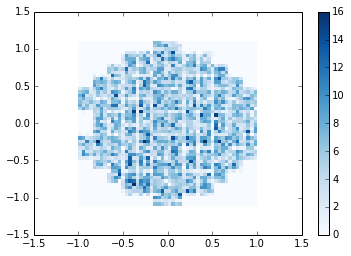

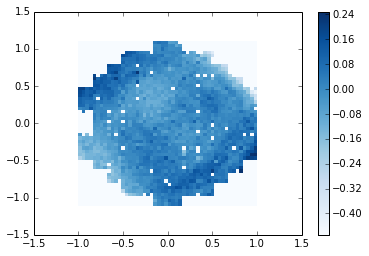

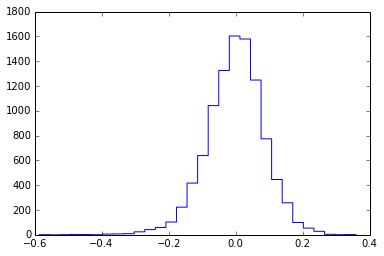

In [41]:
zi = 1
x = X.copy()
y = Y[:, zi].copy()
yerr = Yerr[:, zi].copy()
xval = Xval.copy()
yval = Yval[:, zi].copy()
yerrval = Yerrval[:, zi].copy()

# whiten data
# scale x to +- 1
xnorm = 200.
x /= xnorm
xval /= xnorm

# ycen = y.mean()
# y -= ycen
# yval -= ycen
# ynorm = y.max() - y.min()
# y /= ynorm
# yerr /= ynorm
# yval /= ynorm
# yerrval /= ynorm



Ntrain = 1000
Ntraininds = np.random.choice(len(X), Ntrain, replace=False)
xtrain = x[Ntraininds]
ytrain = y[Ntraininds]
Ntest = 10000
Ntestinds = np.random.choice(len(X), Ntest, replace=False)
x = x[Ntestinds]
y = y[Ntestinds]
yerr = yerr[Ntestinds]
Nvaltest = 10000
Nvaltestinds = np.random.choice(len(Xval), Nvaltest, replace=False)
xval = xval[Nvaltestinds]
yval = yval[Nvaltestinds]
yerrval = yerrval[Nvaltestinds]

counts, xedges, yedges = np.histogram2d(x[:,0], x[:,1], bins=50)
plt.figure()
plt.pcolor(xedges, yedges, counts.T, cmap='Blues')
plt.colorbar()

weighted_counts, xedges, yedges = np.histogram2d(x[:,0], x[:,1], bins=[xedges, yedges], weights=y)
C = weighted_counts.T / counts.T
C = np.where(counts.T == 0, np.nanmin(C), C)

plt.figure()
plt.pcolor(xedges, yedges, C, cmap='Blues')
plt.colorbar()

plt.figure()
_ = plt.hist(y, bins=30, histtype='step')

## George

In [43]:
import george
kernel = 1.0 * george.kernels.Matern32Kernel(0.5, ndim=x.shape[1])
gp = george.GP(kernel)

gp.compute(xtrain)

pars, results = gp.optimize(xtrain, ytrain, sort=False)
gp.kernel[:] = results.x
print(np.exp(results.x))

gp.compute(x)

mu, cov = gp.predict(y, xval)
std = np.sqrt(np.diag(cov))

Optimization terminated successfully.
[  7.53380529e-03   4.41283081e-06]


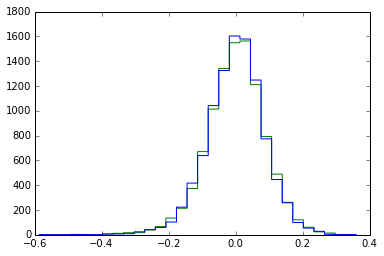

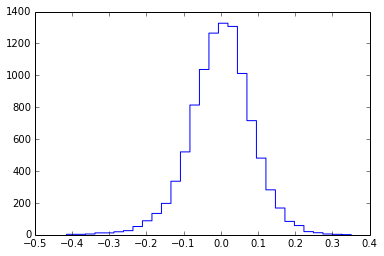

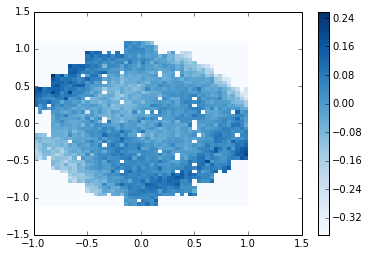

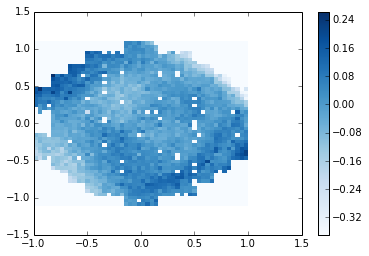

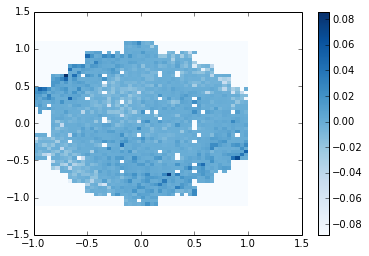

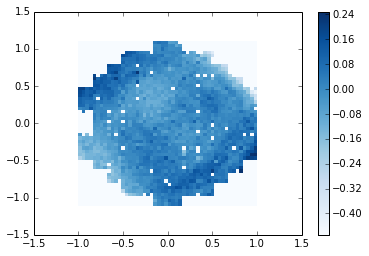

In [45]:
binnum = 50

plt.figure()
_ = plt.hist([y, yval], bins=30, histtype='step')

plt.figure()
_ = plt.hist(yval - mu, bins=30, histtype='step')
make_plots(xval, yval - mu, binnum)
make_plots(xval, yval, binnum)
make_plots(xval, mu, binnum)
make_plots(x, y, binnum)

# HALT

###TODO:

An ideal kernel would have l1 norms on scale of the chip in x and y directions as well as local kernel

In [ ]:
import george
kernel = 1.0 * george.kernels.ExpSquaredKernel(1.0, ndim=x.shape[1])
gp = george.GP(kernel)#, mean=np.mean(y))#, solver=george.HODLRSolver)

gp.compute(x)#, yerr)

pars, results = gp.optimize(x, y, sort=False)
gp.kernel[:] = results.x


mu, cov = gp.predict(y, xval)
std = np.sqrt(np.diag(cov))

plt.figure()
plt.plot(yval, yval, 'bo')
plt.errorbar(yval, mu, yerr=std, fmt='ro')

In [ ]:
counts, xedges, yedges = np.histogram2d(xval[:,0], xval[:,1], bins=10)
plt.figure()
plt.pcolor(xedges, yedges, counts.T, cmap='Blues')
plt.colorbar()

weighted_counts, xedges, yedges = np.histogram2d(xval[:,0], xval[:,1], bins=[xedges, yedges], weights=yval)
C = weighted_counts.T / counts.T
C = np.where(counts.T == 0, np.nanmin(C), C)

plt.figure()
plt.pcolor(xedges, yedges, C, cmap='Blues')
plt.colorbar()

In [ ]:
counts, xedges, yedges = np.histogram2d(xval[:,0], xval[:,1], bins=10)
plt.figure()
plt.pcolor(xedges, yedges, counts.T, cmap='Blues')
plt.colorbar()

weighted_counts, xedges, yedges = np.histogram2d(xval[:,0], xval[:,1], bins=[xedges, yedges], weights=mu)
C = weighted_counts.T / counts.T
C = np.where(counts.T == 0, np.nanmin(C), C)

plt.figure()
plt.pcolor(xedges, yedges, C, cmap='Blues')
plt.colorbar()

In [55]:
import george, emcee

kernel = 1.0 * george.kernels.ExpSquaredKernel(1.0, ndim=x.shape[1])
gp = george.GP(kernel, mean=np.mean(y))#, solver=george.HODLRSolver)

gp.compute(x)#, yerr)

def lnprob(p):
    # Trivial improper prior: uniform in the log.
    if np.any((-10 > p) + (p > 10)):
        return -np.inf
    lnprior = 0.0

    # Update the kernel and compute the lnlikelihood.
    gp.kernel.pars = np.exp(p)
    return lnprior + gp.lnlikelihood(y, quiet=True)


# Set up the sampler.
nwalkers, ndim, nburnin, nrun = 10, len(kernel), 100, 500
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = [kernel.vector + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

In [56]:
%%timeit
## time how long it takes to do a step
_ = sampler.run_mcmc(p0, 1)

1 loops, best of 3: 868 ms per loop


In [ ]:
# RUN!

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, nburnin)

print("Running production chain")
sampler.run_mcmc(p0, nrun)

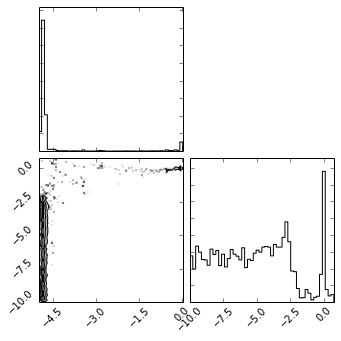

In [61]:
# Look at results
samples = sampler.flatchain
import triangle
triangle.corner(samples);

(array([  6.,   9.,   8.,  20.,  29.,  46.,  38.,  27.,   9.,   8.]),
 array([-0.00318622, -0.00311894, -0.00305165, -0.00298436, -0.00291708,
        -0.00284979, -0.0027825 , -0.00271521, -0.00264793, -0.00258064,
        -0.00251335]),
 <a list of 1 Patch objects>)

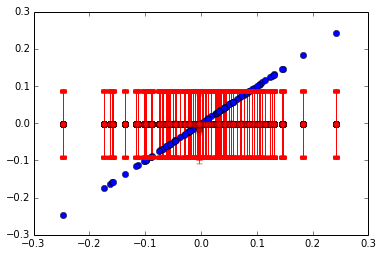

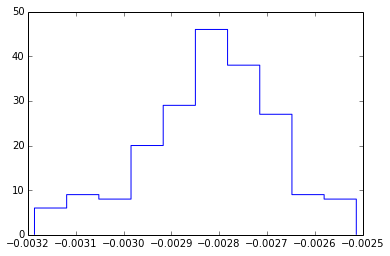

In [62]:
# also look at the log likelihood surface
chain = sampler.chain
lnlikes = []

plt.plot(yval, yval, 'bo')
for i in range(200):
    w = np.random.randint(chain.shape[0])
    n = np.random.randint(nburnin * 3, chain.shape[1])
    gp.kernel.pars = np.exp(chain[w, n])

    mu, cov = gp.predict(y, xval)
    lnlike = -0.5 * (yval - mu).dot(cov).dot(yval - mu)
    lnlikes.append(lnlike)
    
    std = np.sqrt(np.diag(cov))

    plt.errorbar(yval, mu, yerr=std, fmt='ro', alpha=0.3)

plt.figure()
plt.hist(lnlikes, bins=10, histtype='step')

first impliment something that makes SOME kind of prediction

In [262]:
def Fx(X):
    YTrue = np.sqrt(np.sum(X ** 2, axis=1))
    sigma = 0.1
    mu = 0
    Error = np.random.standard_normal(YTrue.shape) * sigma + mu
    Y = YTrue + Error
    
    return Y

X = np.random.random((1000,2)) - 0.5
Y = Fx(X)
Xval = np.sort(np.random.random((10,2)))
Yval = Fx(Xval)

<matplotlib.colorbar.Colorbar instance at 0x1210c4e18>

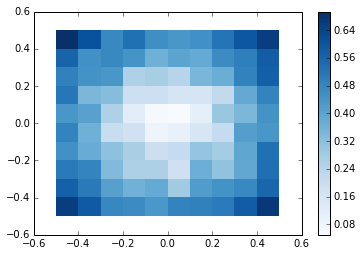

In [263]:
counts, xedges, yedges = np.histogram2d(X[:,0], X[:,1], bins=10)
weighted_counts, xedges, yedges = np.histogram2d(X[:,0], X[:,1], bins=[xedges, yedges], weights=Y)
C = weighted_counts.T / counts.T
C = np.where(counts.T == 0, np.nanmin(C), C)

plt.pcolor(xedges, yedges, C, cmap='Blues')
plt.colorbar()

Desired error not necessarily achieved due to precision loss.
-932.62139227


<Container object of 3 artists>

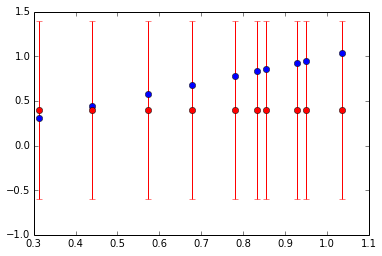

In [266]:
import george

kernel = 1.0 * george.kernels.ExpSquaredKernel(1.0, ndim=X.shape[1])
gp = george.GP(kernel, mean=np.mean(Y))#, solver=george.HODLRSolver)


# Pre-compute the factorization of the matrix.
gp.compute(X, 0.1 * np.ones(len(Y)))

pars, results = gp.optimize(X, Y, sort=False)
gp.kernel[:] = results.x

# Compute the log likelihood.
print(gp.lnlikelihood(Y))

mu, cov = gp.predict(Y, Xval)
std = np.sqrt(np.diag(cov))

plt.figure()
plt.plot(Yval, Yval, 'bo')
plt.errorbar(Yval, mu, yerr=std, fmt='ro')

In [267]:
import george
import emcee

kernel = george.kernels.ExpSquaredKernel(1.0, ndim=X.shape[1])
gp = george.GP(kernel, mean=np.mean(Y))#, solver=george.HODLRSolver)


def lnprob(p):
    # Trivial improper prior: uniform in the log.
    if np.any((-10 > p) + (p > 10)):
        return -np.inf
    lnprior = 0.0

    # Update the kernel and compute the lnlikelihood.
    gp.kernel.pars = np.exp(p)
    return lnprior + gp.lnlikelihood(Y, quiet=True)


# Pre-compute the factorization of the matrix.
gp.compute(X, 0.1 * np.ones(len(Y)))

# Set up the sampler.
nwalkers, ndim = 36, len(kernel)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = [np.log(kernel.pars) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 20)

print("Running production chain")
sampler.run_mcmc(p0, 200)


 

Running burn-in
Running production chain


(array([[-0.5711027 ],
        [-0.68748132],
        [-0.6840855 ],
        [-0.65731668],
        [-0.70950901],
        [-0.66492078],
        [-0.71932297],
        [-0.54188514],
        [-0.64151742],
        [-0.8562049 ],
        [-0.55992558],
        [-0.80630723],
        [-1.13373523],
        [-0.98439388],
        [-0.86553153],
        [-0.75935134],
        [-1.09352175],
        [-0.74347303],
        [-0.72258251],
        [-0.70250912],
        [-0.89947156],
        [-0.80317806],
        [-0.67012182],
        [-1.15483231],
        [-0.44599564],
        [-1.38864484],
        [-0.63850185],
        [-0.90950408],
        [-0.86500855],
        [-0.52773812],
        [-0.69476087],
        [-0.68215138],
        [-0.54068623],
        [-0.86224067],
        [-0.58320793],
        [-0.60742924]]),
 array([ 828.58376657,  829.13256515,  829.12297404,  829.03376868,
         829.18533865,  829.06156128,  829.2035842 ,  828.37586377,
         828.96981548,  829.125083

In [260]:
%%timeit
for p0i in p0[:1]:
    lnprob(p0i)

10 loops, best of 3: 57.9 ms per loop


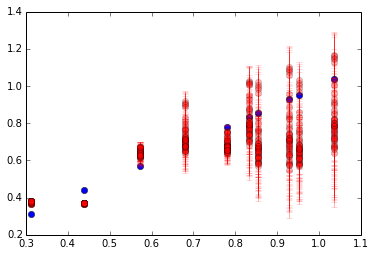

In [270]:
plt.figure()
plt.plot(Yval, Yval, 'bo')
chain = sampler.chain
for i in range(50):
    w = np.random.randint(chain.shape[0])
    n = np.random.randint(20, chain.shape[1])
    gp.kernel.pars = np.exp(chain[w, n])

    mu, cov = gp.predict(Y, Xval)
    std = np.sqrt(np.diag(cov))

    plt.errorbar(Yval, mu, yerr=std, fmt='ro', alpha=0.3)

In [280]:
import triangle
figure = triangle.corner(sampler.chain)

AssertionError: The input sample array must be 1- or 2-D.

-36.7822712121
-0.0606893936826


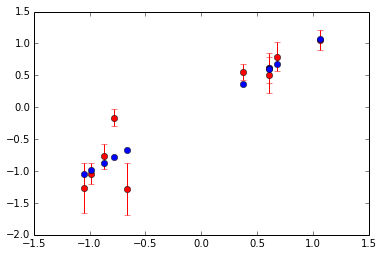

In [216]:
import numpy as np
import matplotlib.pyplot as pl

import george
from george.kernels import ExpSquaredKernel

np.random.seed(1234)

# Generate some fake noisy data.
x = 10 * np.sort(np.random.rand(100,2))
yerr = 0.2 * np.ones_like(x.shape[0])
y = np.sin(np.sqrt(np.sum(x**2,axis=1))) + yerr * np.random.randn(x.shape[0])

# Set up the Gaussian process.
kernel = ExpSquaredKernel(1.0, ndim=2)
gp = george.GP(kernel)

# Pre-compute the factorization of the matrix.
gp.compute(x, yerr)

# Compute the log likelihood.
print(gp.lnlikelihood(y))


xval = 10 * np.sort(np.random.rand(10,2))
# yerrval = 0.2 * np.ones_like(xval)
# yval = np.sin(xval) + yerrval * np.random.randn(len(xval))
yerr = 0.2 * np.ones_like(xval.shape[0])
yval = np.sin(np.sqrt(np.sum(xval**2,axis=1))) + yerr * np.random.randn(xval.shape[0])

# Compute the predictive conditional distribution.
mu, cov = gp.predict(y, xval)
std = np.sqrt(np.diag(cov))

# compute goodness of fit?
print(-0.5 * (yval - mu).dot(cov.dot(yval - mu)))

plt.figure()
plt.errorbar(yval, mu, yerr=std, fmt='ro')
plt.plot(yval, yval, 'bo')

Now impliment something that tries to optimize the hyperparameter

Now impliment an emcee version that tries to give a full marginalization

# Now look at the interpolation from zernike to moment

In [ ]:
from WavefrontPSF.wavefront import Wavefront
WF = Wavefront(nPixels=32, number_electrons=1.)